# Setup

## Installs

In [262]:
# Segmentation
# ! pip install --upgrade mxnet
# ! pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
# ! pip install --upgrade gluoncv

In [263]:
# Edge detection
# ! conda install scikit-image

In [264]:
# Depth estimation
# ! pip install -q transformers

## Imports

In [265]:
# Segmentation
import numpy as np

import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms

import gluoncv
from gluoncv.utils.viz import get_color_pallete
from gluoncv.data.transforms.presets.segmentation import test_transform

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import PIL.Image as pil

# using cpu
ctx = mx.cpu(0)

In [266]:
# Edge detection
from skimage.feature import canny
from matplotlib import cm

In [267]:
# Depth estimation
from transformers import pipeline
import requests

# Read and Transform File

In [268]:
filename = 'images/empty-room.png'

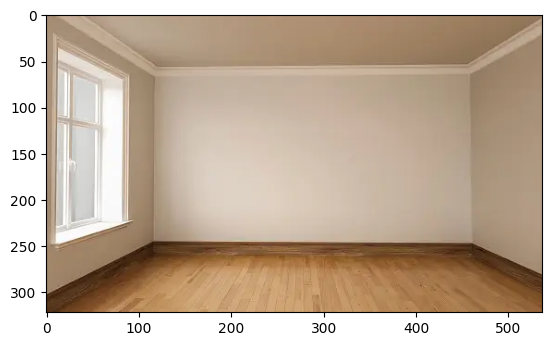

In [269]:
img = image.imread(filename)
plt.imshow(img.asnumpy())
plt.show()

In [270]:
img_t = test_transform(img, ctx)
img_t.shape

(1, 3, 322, 537)

# Semantic Segmentation

In [271]:
semantic_seg_model_psp = model = gluoncv.model_zoo.get_model('psp_resnet101_ade', pretrained=True)
semantic_seg_model_deeplab = gluoncv.model_zoo.get_model('deeplab_resnet101_ade', pretrained=True)
semantic_seg_model_fcn = gluoncv.model_zoo.get_model('fcn_resnet101_voc', pretrained=True)

self.crop_size 480


In [272]:
output = semantic_seg_model_psp.predict(img_t)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = get_color_pallete(predict, 'ade20k')
mask.save('images/outputs/segmentation-output.png')

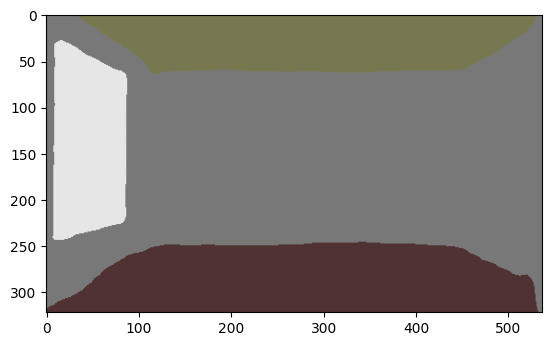

In [273]:
mmask = mpimg.imread('images/outputs/segmentation-output.png')
plt.imshow(mmask)
plt.show()

### Isolate walls

In [274]:
labs = []

for i in range(mmask.shape[0]):
    row = []
    for j in range(mmask.shape[1]):
        row.append(",".join(mmask[i, j].astype(str)))
    labs.append(row)

labs = np.array(labs)
labs.shape

(322, 537)

In [275]:
ind_0, ind_1 = np.where(labs != "0.47058824,0.47058824,0.47058824,1.0")
ind_2, ind_3 = np.where(labs == "0.47058824,0.47058824,0.47058824,1.0")

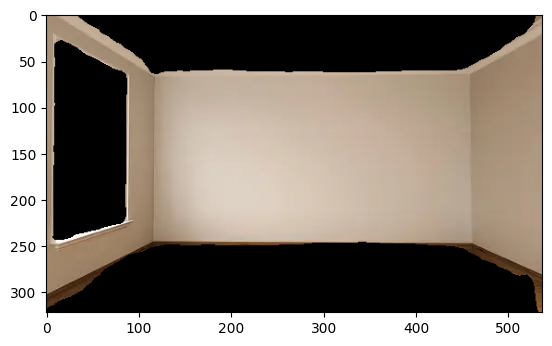

In [276]:
img2 = img.copy().asnumpy()
img2 = img2.astype(float)
img2[ind_0, ind_1] = np.array([0, 0, 0], dtype=float)
img2 = np.clip(img2, 0, 255)
segmented_img = pil.fromarray(img2.astype(np.uint8))
# img2 = img2.reshape((3, img2.shape[2], img2.shape[3]))
# img2 = img2.swapaxes(0, 1)
# img2 = img2.swapaxes(1, 2)
# print(img2.shape)

segmented_img.save('images/outputs/segmentation-walls-only.png')

plt.imshow(segmented_img)
plt.show()



# Edge Detection

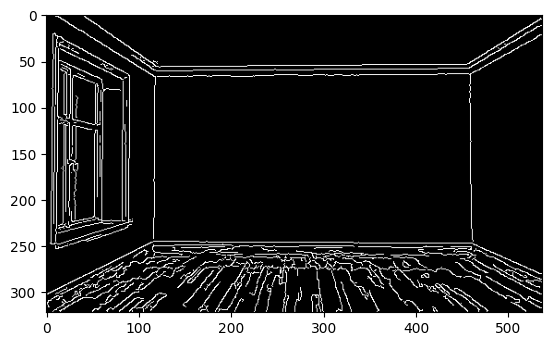

In [399]:
# srcImage = pil.open(filename)
# greyImage = srcImage.convert('L')
# array = np.array(greyImage)

# edges = canny(array, 2, 1, 25)
# edge_map = pil.fromarray(edges)
# edge_map.save('images/outputs/edge-detection-output.png')

import cv2

# Read image
image = cv2.imread(filename)

# Convert image to grayscale
blur = cv2.blur(image, (3, 3))
gray = cv2.cvtColor(blur,cv2.COLOR_BGR2GRAY)
 
# Use canny edge detection
edges = cv2.Canny(gray,15,50,apertureSize=3)

edge_map = pil.fromarray(edges)
edge_map.save('images/outputs/edge-detection-output.png')

plt.imshow(edge_map, cmap=cm.gray)
plt.show()

In [391]:
# https://www.geeksforgeeks.org/line-detection-python-opencv-houghline-method/
import cv2

# Read image
test = np.asarray(image)
blank_image = np.empty( (test.shape[0], test.shape[1], 3) )

# Apply HoughLinesP method to 
# to directly obtain line end points
lines_list =[]
lines = cv2.HoughLinesP(
            edges, # Input edge image
            1, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            threshold=50, # Min number of votes for valid line
            minLineLength=80, # Min allowed length of line
            maxLineGap=10 # Max allowed gap between line for joining them
            )
 
# Iterate over points
for points in lines:
      # Extracted points nested in the list
    x1,y1,x2,y2=points[0]
    # Draw the lines joing the points
    # On the original image
    cv2.line(blank_image,(x1,y1),(x2,y2),(100,0,0),2)
    # Maintain a simples lookup list for points
    lines_list.append([(x1,y1),(x2,y2)])
     
# Save the result image
cv2.imwrite('images/outputs/hough-ouput.png',blank_image)


True

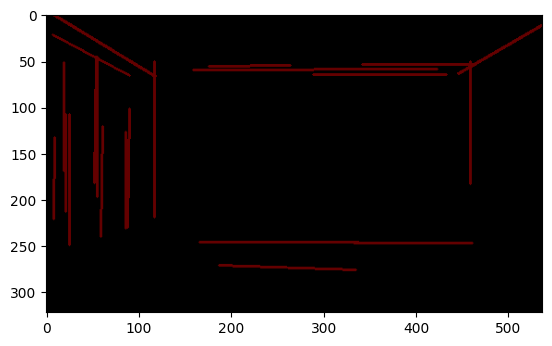

In [390]:
hough_img = cv2.imread('images/outputs/hough-ouput.png')
plt.imshow(hough_img)
plt.show()

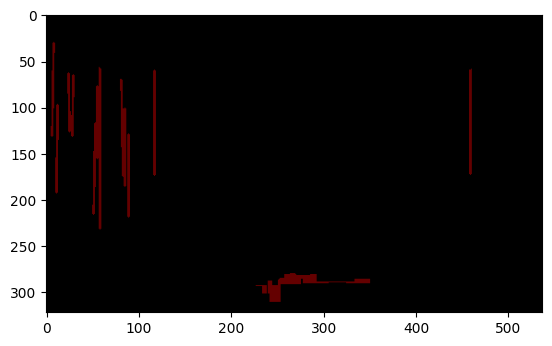

In [280]:
# https://www.youtube.com/watch?v=veoz_46gOkc

kernel = np.ones((20,1), np.uint8)
vertical_lines = cv2.erode(hough_img, kernel, iterations=1)
cv2.imwrite('images/outputs/vertical-hough-ouput.png',vertical_lines)

plt.imshow(vertical_lines)
plt.show()

# Depth Estimation

In [281]:
checkpoint = "vinvino02/glpn-nyu"
depth_estimator = pipeline("depth-estimation", model=checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


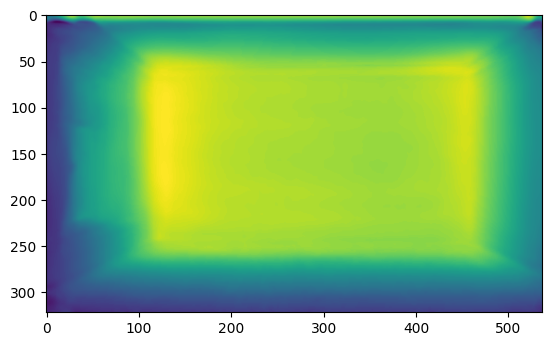

In [282]:
srcImage = pil.open(filename)
predictions = depth_estimator(srcImage)
depth_image = predictions["depth"]
# depth_image.save('images/outputs/depth-output.png')
plt.imsave('images/outputs/depth-output.png', depth_image)
plt.imshow(depth_image)
plt.show()

# Combining Images

In [283]:
# Make depth map more contrasted
# from PIL import ImageEnhance
# new_img = ImageEnhance.Contrast(depth_image).enhance(2.5)
# new_img.save('images/outputs/depth-output.png')
# plt.imshow(new_img)

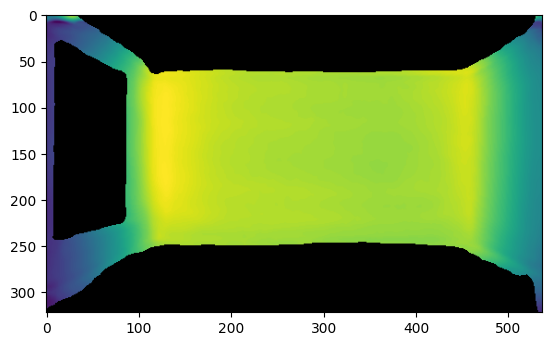

In [284]:
# Combine depth map and segmentation map
test = plt.imread('images/outputs/depth-output.png')[:, :, :3] * 255
# test = np.asarray(new_img.convert('RGB'))
segmented_depth = np.empty( (test.shape[0], test.shape[1], 3) )
segmented_depth[:] = np.nan
segmented_depth[ind_2, ind_3] = test[ind_2, ind_3]
segmented_depth = segmented_depth.astype(dtype=np.uint8)
plt.imshow(segmented_depth)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


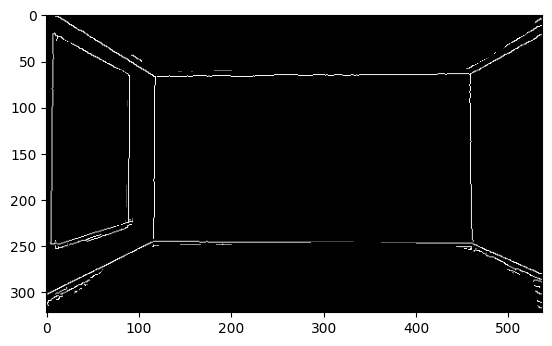

In [405]:
# Combine edge map and segmentation map
edge_map_array = np.asarray(edge_map.convert('RGB'))
segmented_edges = np.empty( (edge_map_array.shape[0], edge_map_array.shape[1], 3) )
segmented_edges[:] = np.nan
segmented_edges[ind_2, ind_3] = edge_map_array[ind_2, ind_3]
plt.imshow(segmented_edges)
segmented_edges = segmented_edges.astype(dtype=np.uint8)

segmented_edges = pil.fromarray(segmented_edges)
segmented_edges.save('images/outputs/segmented-edges.png')
# plt.imshow(edge_map)

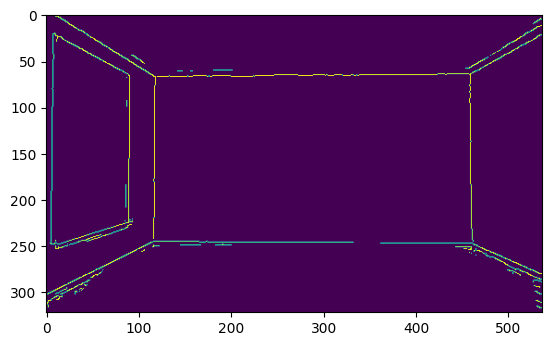

In [365]:
im = cv2.imread('images/outputs/segmented-edges.png')
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, edge_thresh = cv2.threshold(imgray, 0, 1, 0)

# thresh = cv.adaptiveThreshold(imgray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 3, 1)

# kernel = cv.getStructuringElement(cv.MORPH_RECT,(10, 10))
# thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN,kernel)
edge_contours, _ = cv2.findContours(edge_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(edge_thresh)

In [395]:
# https://stackoverflow.com/questions/44127342/detect-card-minarea-quadrilateral-from-contour-opencv?
# fbclid=IwAR3A4AjuD7x8dp07ln4sPJYFyMR1m_u1sb-m1hAbdzc9epuyZcCh5yaij8Y



tuple

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


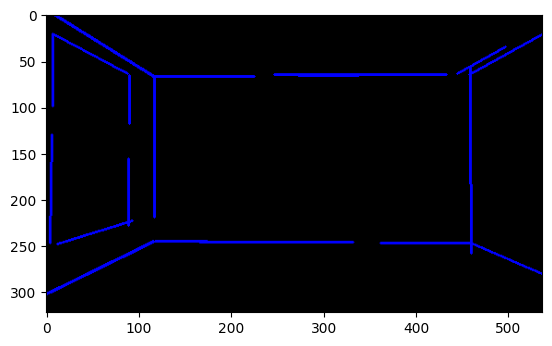

In [360]:
# Hough transform on segmented edges

# Read image
test = np.asarray(segmented_edges)
blank_image = np.empty( (test.shape[0], test.shape[1], 3) )
test = cv2.imread('images/outputs/segmented-edges.png')
test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

# Apply HoughLinesP method to 
# to directly obtain line end points
lines_list =[]
lines = cv2.HoughLinesP(
            test, # Input edge image
            1, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            threshold=50, # Min number of votes for valid line
            minLineLength=45, # Min allowed length of line
            maxLineGap=20 # Max allowed gap between line for joining them
            )
 
# Iterate over points
for points in lines:
      # Extracted points nested in the list
    x1,y1,x2,y2=points[0]
    # Draw the lines joing the points
    # On the original image
    cv2.line(blank_image,(x1,y1),(x2,y2),(0,0,255),2)
    # Maintain a simples lookup list for points
    lines_list.append([(x1,y1),(x2,y2)])
     
# Save the result image
cv2.imwrite('images/outputs/hough-output.png',blank_image)
plt.imshow(blank_image)

In [ ]:
# get coordinates of lines
edge_array = blank_image
test3 = np.sum(edge_array, axis=-1)

ind_6, ind_7 = np.where(test3!=0)

segmented_edges_depth = segmented_depth
segmented_edges_depth[ind_6, ind_7] = [255,0,0]

segmented_edges_depth = segmented_edges_depth.astype(dtype=np.uint8)
plt.imshow(segmented_edges_depth)

### Depth change to find corners

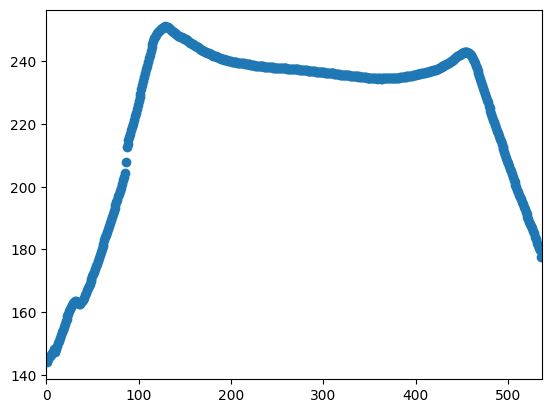

In [339]:
# # Find the mean depth for each column (1px wide) in the wall depth map and plot

test_depth = np.array(depth_image).copy().astype(float)
test_depth[ind_0, ind_1] = np.nan

y = np.nanmean(var, axis=0)
x = range(len(y))

f, ax = plt.subplots(1)
ax.scatter(x, y)
ax.set_xlim(left=0)
ax.set_xlim(right=len(y))
plt.show(f)

##### Difference between predicted and actual depth

c:\Users\Kim\anaconda3\envs\pipeline1\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


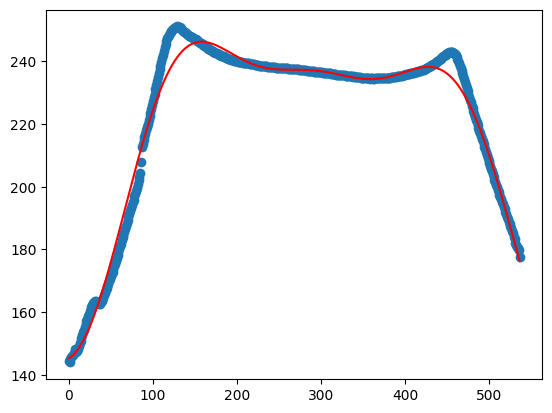

In [341]:
from sklearn.svm import SVR

test_depth = np.array(depth_image).copy().astype(float)
test_depth[ind_0, ind_1] = np.nan
y = np.nanmean(test_depth, axis=0)

# y = test_depth.copy()
x = range(len(y))
plt.scatter(x, y)

clf = SVR(kernel="rbf", C=100).fit(np.array(x).reshape(-1, 1),
                                       np.array(y).reshape(-1, 1))
plt.plot(x, clf.predict(np.array(x).reshape(-1, 1)), color="r")

from sklearn.preprocessing import StandardScaler

preds = clf.predict(np.array(x).reshape(-1, 1)).reshape(-1)
t2 = y.copy().reshape(-1)
z_score_pred_diff = StandardScaler().fit_transform((preds-t2).reshape(-1, 1)).reshape(-1)

##### Getting angles

In [342]:
y = np.nanmean(test_depth, axis=0)
# y = test_depth.copy()
rolling_angle = []

for i in range(len(y)-23):
    t1 = y[i:i+10]
    t2 = y[i+10:i+15]
    t3 = y[i+15:i+25]
    
    t1_m = np.mean(t1)
    t2_m = np.mean(t2)
    t3_m = np.mean(t3)
    
    ba = t1_m - t2_m
    bc = t3_m - t2_m

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    
    # plt.plot([0, 1, 2], [np.mean(t1), t2, np.mean(t3)])
    # print(angle)
    # break
    
    rolling_angle.append(angle)
    
r_angle_z_score = StandardScaler().fit_transform(np.array(rolling_angle).reshape(-1, 1)).reshape(-1)

##### Combining angles and prediction difference

537
16


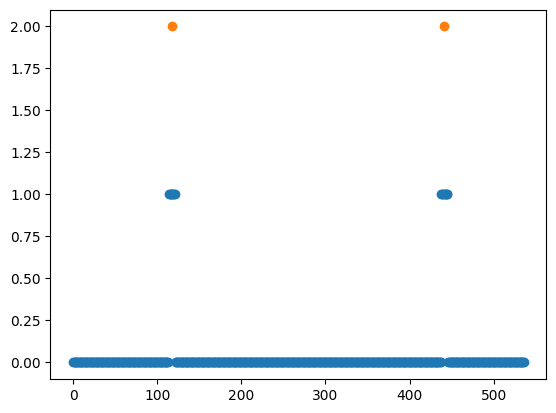

In [343]:
c = z_score_pred_diff.copy()
c[:len(r_angle_z_score)-len(z_score_pred_diff)] *= r_angle_z_score

c1 = c.copy() > 2
c1[c1] = c[c1]

plt.scatter(range(len(c1)), c1)
print(len(c1))

c2 = np.where(c1 == 1)[0]
print(len(c2))


# I used clustering to find the two distinct corner points (currently hard set to look for 2 clusters)
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=2).fit(c2.reshape(-1, 1))
plt.scatter(clf.cluster_centers_, [2, 2])

##### Combining angles and prediction difference

[118 442]


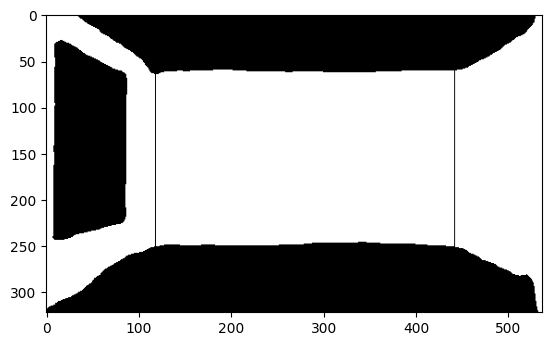

In [346]:
only_walls = np.array(segmented_img.copy())
only_walls[ind_0, ind_1] = [0, 0, 0]
only_walls[ind_2, ind_3] = [255, 255, 255]

corner_inds = np.round(np.ravel(clf.cluster_centers_), 0).astype(int)
only_walls[:, corner_inds] = [0, 0, 0]
print(corner_inds)

plt.imshow(only_walls)

In [347]:
pil_image = pil.fromarray(only_walls)
pil_image.save("images/outputs/segmented-with-corners.png")

## Finding Geometry

##### Extracting Geometry

In [392]:
im = cv2.imread('images/outputs/edge-detection-output.png')
assert im is not None, "file could not be read, check with os.path.exists()"
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 0, 1, 0)

# thresh = cv2.adaptiveThreshold(imgray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 1)

# kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10, 10))
# thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

c:\Users\Kim\anaconda3\envs\pipeline1\lib\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


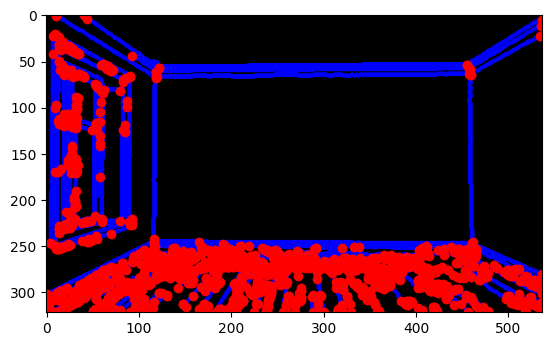

In [387]:
im_2 = im.copy()
final_cnt = []

for cnt in contours:
    x1,y1 = cnt[0][0]
    approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), False)

    # cv.putText(im_2, 'Rectangle', (x1, y1), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
    im_2 = cv2.drawContours(im_2, [cnt], -1, (0,0,255), 3)
    plt.scatter(approx[:, 0, 0], approx[:, 0, 1], color="r")
    final_cnt.append(approx[:, 0, :])
    
plt.imshow(im_2)
final_cnt = np.array(final_cnt)

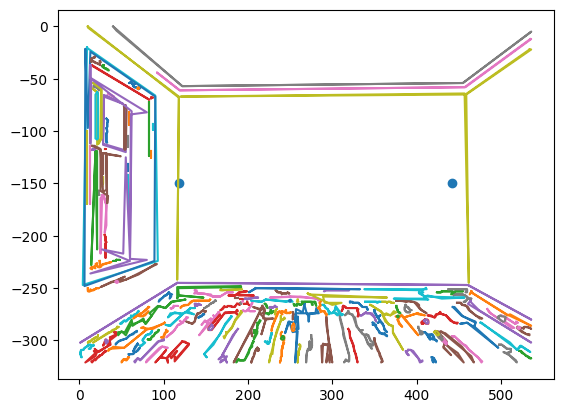

In [388]:
for i in range(len(final_cnt)):
    data = np.append(final_cnt[i], final_cnt[i][0]).reshape(-1, 2)
    
    plt.plot(np.array(data)[:, 0], -np.array(data)[:, 1])
    
plt.scatter(corner_inds, [-150, -150])

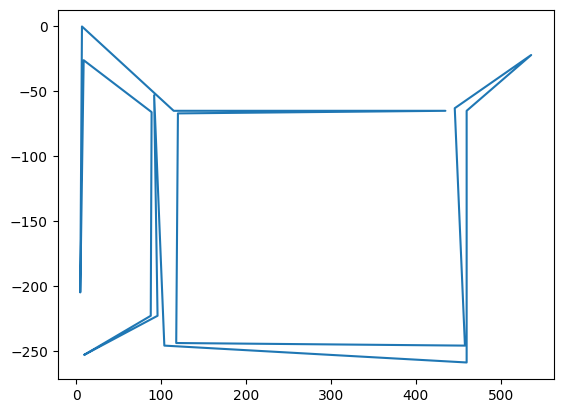

In [363]:
corner_adj_geom = []

for i in range(len(final_cnt)):
    data = np.array(final_cnt[i])[:, 0]
    limit = 5
    
    diff_1 = np.sum(np.abs(data.copy() - corner_inds[0]) <= limit)
    diff_2 = np.sum(np.abs(data.copy() - corner_inds[1]) <= limit)
    
    if diff_1 >= 2 or diff_2 >= 2:
        corner_adj_geom.append(final_cnt[i])
        
for i in range(len(corner_adj_geom)):
    data = np.append(corner_adj_geom[i], corner_adj_geom[i][0]).reshape(-1, 2)
    
    plt.plot(np.array(data)[:, 0], -np.array(data)[:, 1])

In [334]:
# y_round = np.round(y.copy(), 0).astype(int)
# y_round = y_round - np.amin(y_round)
# matrix = np.zeros((np.amax(y_round)+1, len(x), 3))

# for i in range(len(x)):
#     matrix[y_round[i], i] = [255, 255, 255]

# matrix = matrix.astype(np.uint8)

# matrix = pil.fromarray(matrix)
# matrix.save("images/outputs/matrix-test.png")

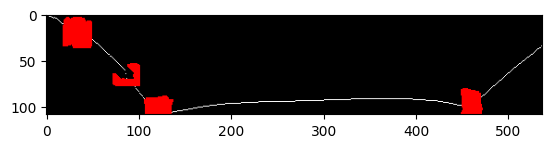

In [335]:
# # Use cv2 method to detect 'corners'

# image = cv2.imread('images/outputs/matrix-test.png')
# image
# operatedImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
  
# # modify the data type 
# # setting to 32-bit floating point 
# operatedImage = np.float32(operatedImage) 
  
# # apply the cv2.cornerHarris method 
# # to detect the corners with appropriate 
# # values as input parameters 
# # dest = cv2.cornerHarris(operatedImage, 50, 29, 0.24)
# dest = cv2.cornerHarris(operatedImage, 30, 5, 0.07)
  
# # Results are marked through the dilated corners 
# dest = cv2.dilate(dest, None) 
  
# # Reverting back to the original image, 
# # with optimal threshold value 
# image[dest > 0.01 * dest.max()]=[255, 0, 0]



# image = pil.fromarray(image.astype(np.uint8))
# image.save("images/outputs/corners.png")
# plt.imshow(image)

In [292]:
# # corners = mpimg.imread('images/outputs/corners.png')
# corners = plt.imread('images/outputs/corners.png')[:, :, :3] * 255

# colours = []

# for i in range(corners.shape[0]):
#     row = []
#     for j in range(corners.shape[1]):
#         row.append(",".join(corners[i, j].astype(str)))
#     colours.append(row)

# colours = np.array(colours)


In [293]:
# # Find indices where there is red
# ind_x, ind_y = np.where(colours == "255.0,0.0,0.0")
# # Round numbers to nearest 10 and then take only unique ones
# ind_y = np.round(ind_y, -1)
# ind_y = np.unique(ind_y)

# first_range = 0
# new_list = []

# # If numbers are within 50 of eachother, only keep one of them
# for n in ind_y:
#     if n - first_range <= 50:
#         pass
#     else:
#         new_list = np.append(new_list, n)
#         first_range = n

# new_list = new_list.astype(int)
# print(new_list)

[110 450]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


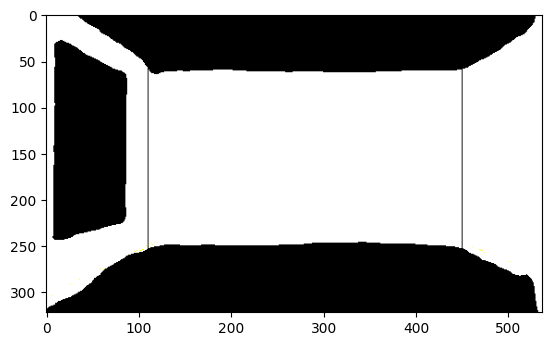

In [294]:
# wall_segments = np.asarray(segmented_img.convert('RGB'))
# wall_segments = wall_segments.astype(float)
# wall_segments[:, new_list] = np.array([0, 0, 0], dtype=float)

# plt.imshow(wall_segments)